# Plotting sync

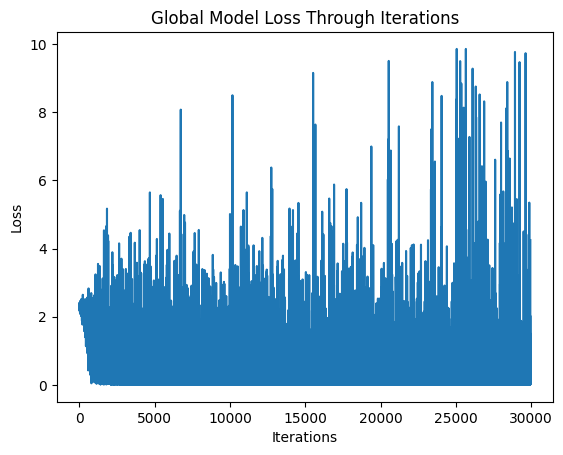

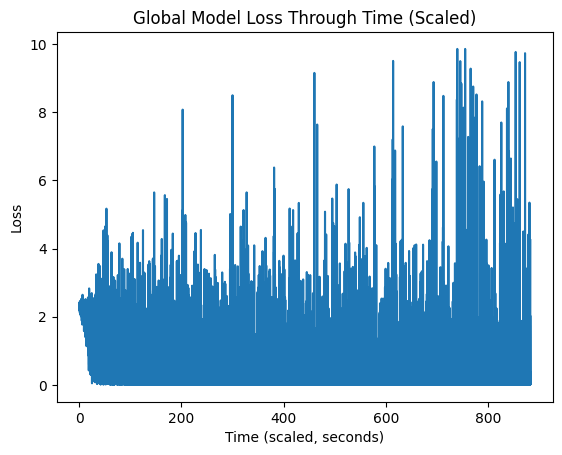

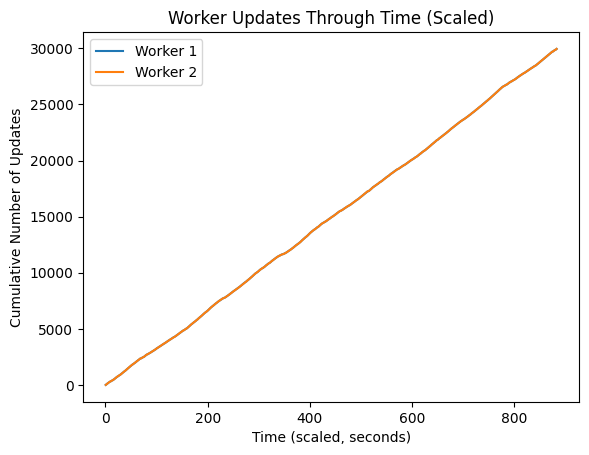

In [4]:
import re
import datetime
import matplotlib.pyplot as plt

def extract_info(logfile):
    time_pattern = re.compile(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}")
    loss_pattern = re.compile(r"Global model loss is (\d+\.\d+)")
    worker_pattern = re.compile(r"PS got (\d)/\d updates \(from Worker_(\d)")

    iteration_losses = []
    time_losses = []
    worker_updates = {1: [], 2: []}
    first_timestamp = None

    with open(logfile, 'r') as f:
        for line in f:
            time_match = time_pattern.search(line)
            loss_match = loss_pattern.search(line)
            worker_match = worker_pattern.search(line)

            if time_match:
                timestamp = datetime.datetime.strptime(time_match.group(), "%Y-%m-%d %H:%M:%S,%f")
                if first_timestamp is None:
                    first_timestamp = timestamp
                timestamp = (timestamp - first_timestamp).total_seconds()

            if loss_match:
                loss = float(loss_match.group(1))
                iteration_losses.append(loss)
                time_losses.append((timestamp, loss))

            if worker_match:
                worker_id = int(worker_match.group(2))
                worker_updates[worker_id].append(timestamp)

    return iteration_losses, time_losses, worker_updates

def plot_losses(iteration_losses, time_losses, worker_updates):
    # Global model loss through iterations
    plt.figure()
    plt.plot(iteration_losses)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Global Model Loss Through Iterations")

    # Global model loss through time
    plt.figure()
    time_values = [t for t, _ in time_losses]
    loss_values = [l for _, l in time_losses]
    plt.plot(time_values, loss_values)
    plt.xlabel("Time (scaled, seconds)")
    plt.ylabel("Loss")
    plt.title("Global Model Loss Through Time (Scaled)")

    # Worker updates through time
    plt.figure()
    for worker_id, timestamps in worker_updates.items():
        update_counts = range(1, len(timestamps) + 1)
        plt.plot(timestamps, update_counts, label=f"Worker {worker_id}")

    plt.xlabel("Time (scaled, seconds)")
    plt.ylabel("Cumulative Number of Updates")
    plt.title("Worker Updates Through Time (Scaled, Synchronous SGD)")
    plt.legend()

    plt.show()


logfile = "log_sync.log"
iteration_losses, time_losses, worker_updates = extract_info(logfile)
plot_losses(iteration_losses, time_losses, worker_updates)

# Plot for async

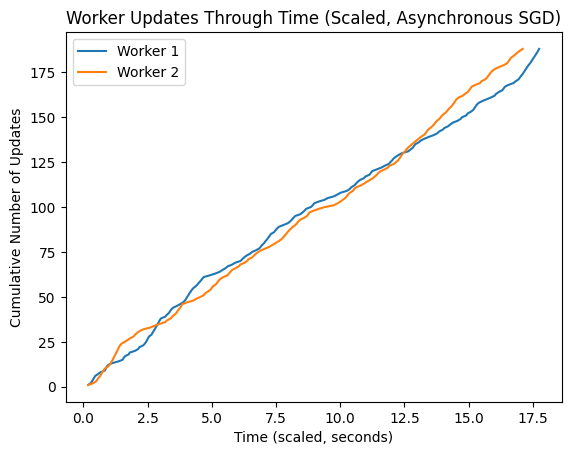

In [5]:
def extract_info_async(logfile):
    time_pattern = re.compile(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}")
    worker_pattern = re.compile(r"PS got update from Worker_(\d)")

    worker_updates = {1: [], 2: []}
    first_timestamp = None

    with open(logfile, 'r') as f:
        for line in f:
            time_match = time_pattern.search(line)
            worker_match = worker_pattern.search(line)

            if time_match:
                timestamp = datetime.datetime.strptime(time_match.group(), "%Y-%m-%d %H:%M:%S,%f")
                if first_timestamp is None:
                    first_timestamp = timestamp
                timestamp = (timestamp - first_timestamp).total_seconds()

            if worker_match:
                worker_id = int(worker_match.group(1))
                worker_updates[worker_id].append(timestamp)

    return worker_updates

def plot_worker_updates(worker_updates):
    # Worker updates through time
    plt.figure()
    for worker_id, timestamps in worker_updates.items():
        update_counts = range(1, len(timestamps) + 1)
        plt.plot(timestamps, update_counts, label=f"Worker {worker_id}")

    plt.xlabel("Time (scaled, seconds)")
    plt.ylabel("Cumulative Number of Updates")
    plt.title("Worker Updates Through Time (Scaled, Asynchronous SGD)")
    plt.legend()

    plt.show()
    
logfile_async = "log_async.log"
worker_updates_async = extract_info_async(logfile_async)
plot_worker_updates(worker_updates_async)